# A Computational Model for the ICAP Framework: Exploring Agent-Based Modeling as an AIED Methodology


#### Knowledge Graphs

In [ ]:
import math
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
# !pip install mesa
from mesa import Agent, Model
from mesa.time import BaseScheduler
from mesa.datacollection import DataCollector
import seaborn as sns
sns.set()

from scipy.stats import ttest_ind

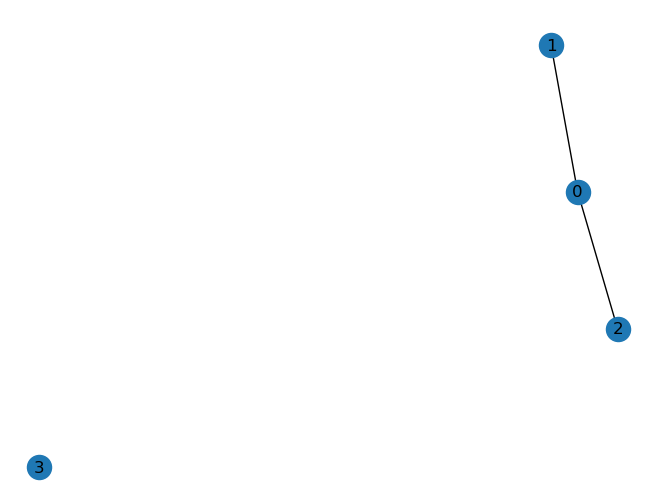

In [ ]:
# Make a graph with the following four edges among nodes 0, 1, 2, and 3.
G = nx.Graph([(0, 1), (0, 2), (1, 2), (2, 3)])

# Add a new node to the graph.
G.add_node(4)

# Draw the graph
# nx.draw(G, with_labels=True)

F = nx.Graph([(0, 1), (0, 2), (1, 5), (3, 5)])
# nx.draw(F, with_labels=True)
nx.draw(nx.intersection(G, F), with_labels=True)

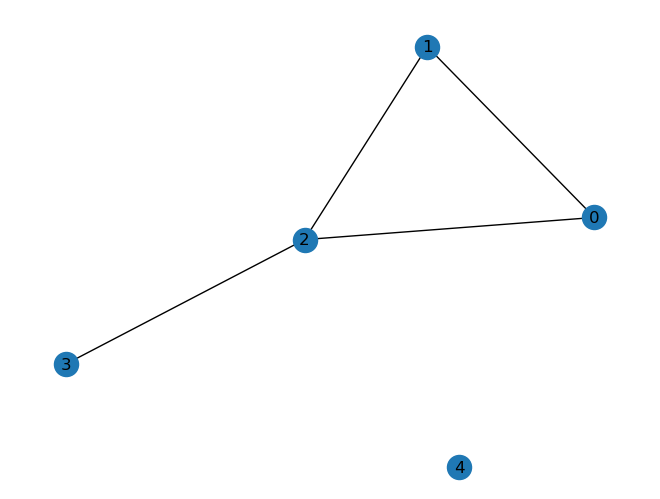

In [ ]:
nx.draw_kamada_kawai(G, with_labels=True)

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (2, 3), (4, 5), (4, 6), (4, 7), (4, 8), (5, 6), (5, 7), (6, 7), (8, 9), (8, 10), (8, 11), (8, 12), (9, 10), (9, 11), (10, 11), (12, 13), (12, 14), (12, 15), (12, 16), (13, 14), (13, 15), (14, 15), (16, 17), (16, 18), (16, 19), (16, 20), (17, 18), (17, 19), (18, 19), (20, 21), (20, 22), (20, 23), (20, 24), (21, 22), (21, 23), (22, 23), (24, 25), (24, 26), (24, 27), (24, 28), (25, 26), (25, 27), (26, 27), (28, 29), (28, 30), (28, 31), (28, 32), (29, 30), (29, 31), (30, 31), (32, 33), (32, 34), (32, 35), (32, 36), (33, 34), (33, 35), (34, 35), (36, 37), (36, 38), (36, 39), (36, 40), (37, 38), (37, 39), (38, 39), (40, 41), (40, 42), (40, 43), (40, 44), (41, 42), (41, 43), (42, 43), (44, 45), (44, 46), (44, 47), (44, 48), (45, 46), (45, 47), (46, 47), (48, 49), (48, 50), (48, 51), (48, 52), (49, 50), (49, 51), (50, 51), (52, 53), (52, 54), (52, 55), (52, 56), (53, 54), (53, 55), (54, 55), (56, 57), (56, 58), (56, 59), (56, 60), (57, 

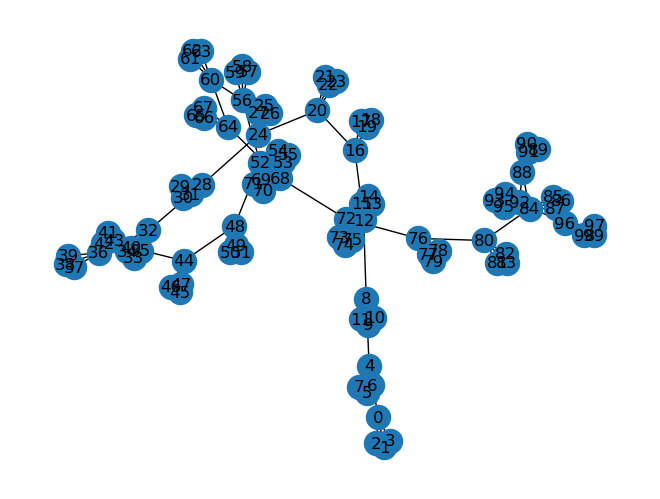

In [ ]:
nodes_list = [i for i in range(0, 100)]
source_graph = nx.Graph()
for j in range(0, len(nodes_list), 4):
  g = nx.complete_graph(nodes_list[j:j+4])
  source_graph = nx.union(source_graph, g)
  if j >= 4:
    source_graph.add_edge(nodes_list[j - 4], nodes_list[j])
nx.draw(source_graph, with_labels = True)
source_graph.edges

In [ ]:
for (u, v) in G.edges():
  G.edges[u,v]['weight'] = round(random.random(), 2)
G.edges.data()

EdgeDataView([(0, 1, {'weight': 0.23}), (0, 2, {'weight': 0.75}), (1, 2, {'weight': 0.8}), (2, 3, {'weight': 0.25})])

Here's a complete graph with 17 nodes. A complete graph has all possible edges. (Alternatively, we could call it a piece of art!)

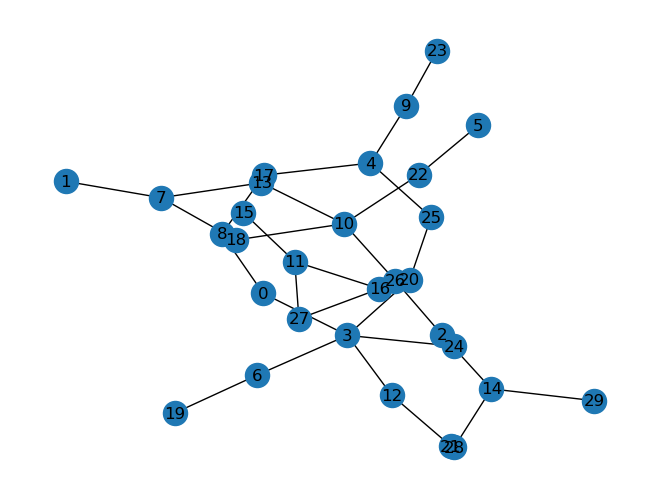

In [ ]:
G = nx.complete_graph(17)
G = nx.watts_strogatz_graph(30, 2, 1)
nx.draw_kamada_kawai(G, with_labels=True)

We can also make random graphs, which we will use below. The function below will create a Watts-Strogatz graph, a random graph with 20 nodes where each node is connected to the 3 closest nodes (in number), but with probability 0.4 each edge is "re-wired" to a random node.

EdgeView([(0, 1), (0, 19), (0, 2), (0, 18), (0, 13), (0, 10), (0, 6), (1, 2), (1, 3), (1, 19), (1, 5), (1, 10), (2, 3), (2, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (5, 16), (6, 7), (6, 8), (7, 8), (7, 9), (7, 14), (7, 15), (7, 16), (7, 17), (8, 9), (8, 10), (9, 10), (9, 11), (10, 11), (10, 12), (10, 17), (11, 12), (11, 13), (11, 18), (12, 13), (12, 14), (12, 17), (13, 14), (13, 15), (14, 15), (14, 16), (15, 16), (15, 17), (16, 17), (16, 18), (17, 18), (17, 19), (18, 19)])

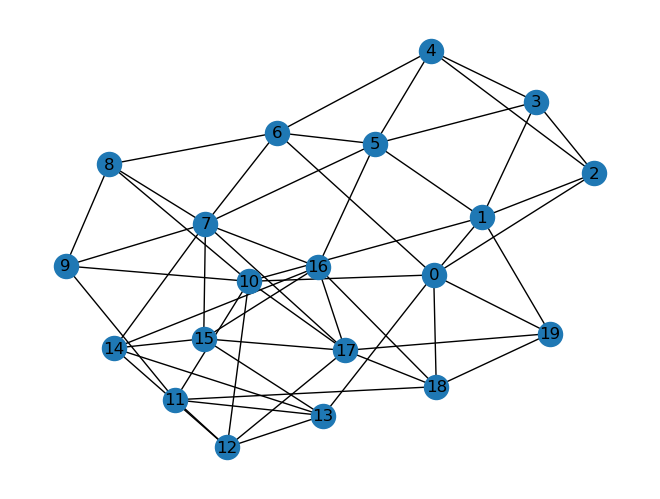

In [ ]:
# G = nx.watts_strogatz_graph(30, 3, 12)
G = nx.newman_watts_strogatz_graph(20, 5, 0.4)
nx.draw_kamada_kawai(G, with_labels=True)
G.edges

#### ICAP Agent-Based Model High-Level Description

Okay, now let's move on to the agent-based model. Before describing how the ABM is implemented in code, I will give a high-level description of the ABM. The model is composed of several agents (which we will refer to as learners), each of which can be classified as being either **passive**, **active**, **constructive**, or **interactive**. Of course in reality, a learner can use different modes of engagement, but for simplicity, here we are assuming that each learner will engage in the same mode for the duration of a simulation.

The model is also given a knowledge graph, which determines the relationships between different nodes. We will refer to the weight between node $i$ and $j$ as $w_{ij}$. If there is no edge between node $i$ and $j$, then $w_{ij} = 0$.

Each learner has a knowledge state, which will be represented as a list of nodes in the knowledge graph and a list of edges in the knowledge graph.

Each step of the model will consist of introducing (or teaching) a particular node of the knowledge graph to each learner. Each learner has some chance of learning that node (as well as possibly edges or other nodes) according to a set of rules, defined as follows:
* passive: The learner learns the node with some fixed probability. The probability is currently defined as $\text{sigmoid}(0.5) \approx 0.62$.
* active: The learner learns the node with some probability that increases as a sigmoidal function of the sum of the edge weights for every edge connected to the given node. Specifically, for node $i$, the probability is given by $\text{sigmoid}(0.5 + \sum_{j} w_{ij})$.
* constructive: The learner learns the node as an active learner, and if they do, they can learn up to two neighboring nodes, each with probability given by $\text{sigmoid}(-0.5 + \sum_{j} w_{ij})$.
* interactive: *You will be asked to explain how the interactive learner learns below.*

For active, constructive, and interactive learners, the learner not only learns the node, but also learns all edges from the node to nodes currently in their knowledge state. (Therefore, the learner's knowledge state includes all edges among nodes they have learned so far.)

#### ICAP Agent-Based Model Implementation

Now let's discuss how the model is implemented. We'll be using the `mesa` module. To use Mesa, we utilize two class called `Agent` and `Model`. You don't really need to understand what a class is in Python, but basically it defines a kind of object or entity. In this case, the `Agent` class will represent a single agent and rules for how it behaves at each `step`. We can create many unique agents. The `Model` class represents the agent-based model as a whole. The `Agent` and `Model` classes that Mesa provide are like templates that we can use to build our own classes. In our case, we create a `Learner` class to represent the agents, and the `ICAPModel` class to represent the model. Let's begin by walking through the `ICAPModel` class.

In [ ]:
class ICAPModel(Model):
  def __init__(self, knowledge_graph, agents_type, time_per_step_dict = None, 
               max_time = 100.0, nodes_known_before=None, fc=False, ps=False, 
               different_prior_knowledge=False, complement_knowledge=False):

    self.agents_type = agents_type
    self.agent_types_changed = {x: False for x in agents_type.keys()}
    # Should be a dictionary mapping learner type strings to integers
    if time_per_step_dict != None:
      self.time_dict = time_per_step_dict
    else:
      self.time_dict = {'non-learner': 1, 'passive': 1, 'active': 1, 'constructive': 1, 'interactive': 1}
    self.max_time = max_time
    self.fc = fc # A boolean indiciating whether we are simulating a flipped classroom
    self.ps = ps # A boolean indiciating whether we are simulating a different pairing strategies
    self.schedule = BaseScheduler(self)
    agent_count = 0
    self.complement_knowledge = complement_knowledge
    self.nodes_known_before = nodes_known_before
    self.focal_nodes = []
    if nodes_known_before:
      known_nodes = random.sample(list(knowledge_graph.nodes), nodes_known_before)
    
    for learner_type, config in self.agents_type.items():
      for _ in range(config['count']):
        if nodes_known_before:
          if different_prior_knowledge and nodes_known_before:
            known_nodes = random.sample(list(knowledge_graph.nodes), nodes_known_before)
          a = Learner(agent_count, self, learner_type, config, known_nodes=known_nodes)
        else:
          a = Learner(agent_count, self, learner_type, config)
        agent_count += 1
        self.schedule.add(a)

    self.knowledge_graph = knowledge_graph
    self.node = 0

    # This just sets up data collection for each variable of interest for every 
    # agent at every step, which can later be extracted as a dataframe.
    self.datacollector = DataCollector(
      model_reporters={},
      agent_reporters={'AgentType': 'type', 'GroupType': 'group_type', 'Knowledge':'knowledge', 
        'PosttestKnowledge': 'posttest_knowledge', 'KnowledgeLinks':'knowledge_links', 'Time': 'time'}
      )
    self.pairs = {}
    for k in agents_type.keys():
      self.pair_agents(k)

  # Randomly pairs each interactive agent with another interactive agent.
  def pair_agents(self, group_type=None):
    if group_type and not self.fc:
      interactive_agents = [agent for agent in self.schedule.agents if 
                              agent.type == 'interactive' and agent.group_type == group_type]
    else:
      interactive_agents = [agent for agent in self.schedule.agents if 
                              agent.type == 'interactive']
    random.shuffle(interactive_agents)
    for i in range(0, len(interactive_agents) - 1, 2):
      if self.complement_knowledge:
        known_nodes = random.sample(list(self.knowledge_graph.nodes), self.nodes_known_before)
        interactive_agents[i].known_nodes = known_nodes
        known_nodes_complement = random.sample(list(set(self.knowledge_graph.nodes) - set(known_nodes)),
                                               self.nodes_known_before)
        interactive_agents[i + 1].known_nodes = known_nodes_complement
      self.pairs[interactive_agents[i]] = interactive_agents[i + 1]
      self.pairs[interactive_agents[i + 1]] = interactive_agents[i]
      
  def step(self, node_skip = 1):
    if self.schedule.time == 0:
      for learner in self.schedule.agents:
        learner.update_focal_nodes()
    # This collects the data as specified above for the current step.
    self.datacollector.collect(self)
    self.schedule.step()
    
    for agent_type, changed in self.agent_types_changed.items():
      if changed:
        self.pair_agents(group_type=agent_type)
        self.agent_types_changed[agent_type] = False
        
    self.node += node_skip
    # self.focal_nodes = self.focal_nodes + [self.node]
    graph_size = self.knowledge_graph.number_of_nodes()
    
    if self.ps:
      for k in self.agents_type.keys():
        self.pair_agents(k)
    
    if self.node >= graph_size:
        if graph_size % node_skip == 0:
            self.node -= graph_size - 1
        else: self.node -= graph_size

Let's now discuss the `Learner` class. The `__init__` function for `Learner` takes several arguments:

*   `self`: This refers to the learner itself. See above.
*   `id`: This is a unique id for this agent. (Required by `mesa`.)
*   `model`: This is an instance of the `ICAPModel` class, and it represents the agent-based model that creates and runs this agent. (Required by `mesa.`)
*   `learner_type`: This is a string that designates the type of learner: `'passive'`, `'active'`, `'constructive'`, or `'interactive'`.
*   `time_per_step`: This is a number specifying how much time this agent spends on each step.

The rest of the init function mainly just initializes a few attributes for the learner. For example `self.knowledge = []` initializes the "knowledge state" of each learner to be an empty list.

The key methods in the learner class are as follows:
*  `step` implements a step that the agent can take. The particularities of the step will depend on the type of agent
*  `learn` implements the actual learning of a node. It tests whether the agent learns a given node and if so adds that node to `self.knowledge`. It also adds the associated edges for active, constructive, and interactive agents
* `interactive_learn` implements an interactive session between two interactive learners that are paired together. It calls on the `learn` function to implement the actual learning.

There is one additional helper function called `sort_neighbors`, which helps us determine which neighboring nodes to infer in the case of `constructive` and `interactive` agents. You don't have to understand the code for this function.

Please read through the `step`, `learn`, and `interactive_learn` functions to understand what they do. You don't need to understand all the syntactic details, but you are expected to understand them to the extent to be able to answer the next question. Make sure to run the cell too!

In [ ]:
# This is just a function that implements the sigmoid function (logistic curve).
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [ ]:
sigmoid(1.93)

0.8732494198778592

In [ ]:
class Learner(Agent):
  def __init__(self, id, model, learner_type, time_config, known_nodes: list = None):
    super().__init__(id, model)
    self.knowledge = []
    self.posttest_knowledge = [] # Indicates the number of learned focal nodes
    self.knowledge_links = []
    self.time_config = time_config
    # if self.type == 'interactive':
    self.interacted = False
    self.time = 0.0
    self.group_type = time_config['name']
    self.type = list(time_config["order"].keys())[0]
    self.prior_knowledge = []
    if known_nodes:
      self.prior_knowledge = known_nodes
      self.knowledge = self.prior_knowledge

  # This function implements how agents can learn a node and returns a Boolean
  # specifying whether or not they have learned the node. It has three parameters:
  #  - node: the node to be learned
  #  - easiness: a number specifying how easy the node is to be learned. This parameter
  #              will go into a sigmoidal function to determine the probability of 
  #              learning the node.   
  #  - active: This is a boolean that should be true the agent is an active,
  #            constructive, or interactive learner, and False if the agent
  #            is a passive learner. If True, it adds the sum of the weights
  #            from neighboring nodes in self.knowledge into the sigmoidal
  #            function, and if the node is learned, it adds all the edges to
  #            the node to self.knowledge_links. 
  
  def get_learning_strength_for_node(self, node, partner=None):
    if not partner:
      subgraph_nodes = self.knowledge + [node]
      subgraph = self.model.knowledge_graph.subgraph(subgraph_nodes)
      return subgraph.degree(node, weight='weight')
    else:
      self_subgraph_nodes = self.knowledge + [node]
      self_subgraph = self.model.knowledge_graph.subgraph(self_subgraph_nodes)
      partner_subgraph_nodes = partner.knowledge + [node]
      partner_subgraph = partner.model.knowledge_graph.subgraph(partner_subgraph_nodes)
      intersection_graph = nx.intersection(self_subgraph, partner_subgraph)
      for (u, v) in intersection_graph.edges():
        intersection_graph.edges[u, v]['weight'] = self.model.knowledge_graph.edges[u, v]['weight']
      all_edges = (1/2) * partner_subgraph.degree(node, weight='weight') + self_subgraph.degree(node, weight='weight')
      return all_edges - (1/2) * intersection_graph.degree(node, weight='weight') 

  
  def learn(self, node, easiness, active = True, partner=None):
      subgraph = self.model.knowledge_graph.subgraph(self.knowledge + [node])
      prob = self.random.random()
      if active:
        learning_strength = self.get_learning_strength_for_node(node, partner)
      else:
        learning_strength = 0
      if prob < sigmoid(easiness + learning_strength):
        self.knowledge = self.knowledge + [node]
        if node in self.model.focal_nodes:
          self.posttest_knowledge = self.posttest_knowledge + [node]
        if active:
          self.knowledge_links = self.knowledge_links + list(subgraph.edges(node))
        return True
      else:
        return False

  # This function is given a node and returns the list of neighbors for that node
  # sorted by how many neighbors each neighboring node has in self.knowledge.
  # Ties are broken randomly.
  def sort_neighbors(self, node):
      neighbors = self.model.knowledge_graph.neighbors(node)
      key = lambda n: len(set(self.model.knowledge_graph.neighbors(n)).intersection(set(self.knowledge))) + random.random()
      return sorted(neighbors, key = key, reverse=True)

  # This function implements an interactive learning session between two agents
  # (self and partner). The function does not return anything but modifies
  # the knowledge state directly
  def interactive_learn(self, partner):
      neighbors = self.sort_neighbors(self.model.node)
      unlearned_neighbors = [node for node in neighbors if node not in self.knowledge]
      if unlearned_neighbors:
        inferred = self.learn(unlearned_neighbors[0], -1, partner=partner)
        if inferred and unlearned_neighbors[0] not in partner.knowledge:
          co_inferred = partner.learn(unlearned_neighbors[0], -1, partner=self)

  def update_focal_nodes(self):
    if self.prior_knowledge:
      self.posttest_knowledge = [x for x in self.prior_knowledge if x in self.model.focal_nodes]
  # This function implements a single step that the agent takes. It has three parameters:
  # It only takes a step if the agent has enough time (as measured by self.time)
  # as compared to the maximum alloted time for the model (self.model.max_time).
  # The agent then takes the appropriate step depending on the agent type.
  # Most of the work happens in the self.learn and self.interactive_learn methods.
  def step(self):
    if self.time <= self.model.max_time - self.model.time_dict[self.type]:
      if self.type == 'non-learner':
        pass
      if self.type == 'passive':
        if self.model.node not in self.knowledge:
          self.learn(self.model.node, 0, active = False)

      elif self.type == 'active':
        if self.model.node not in self.knowledge:
          self.learn(self.model.node, 0)

      elif self.type == 'constructive':
        if self.model.node not in self.knowledge:
          learned = self.learn(self.model.node, 0.25)
        else: learned = True
        if learned:
          neighbors = self.sort_neighbors(self.model.node)
          unlearned_neighbors = [node for node in neighbors if node not in self.knowledge]
          if unlearned_neighbors:
            inferred = self.learn(unlearned_neighbors[0], -1)
            if len(unlearned_neighbors) > 1:
              inferred = self.learn(unlearned_neighbors[1], -3)
    
      elif self.type == 'interactive':
        # self.interacted will be true if the agent's partner already had a step.
        # If it is True, it means the agent already took a step (during the partner's)
        # "turn", and so we can skip this step and set self.interacted to be False.
        if self.interacted:
          self.interacted = False
        else:
          partner = self.model.pairs[self]
          
          if self.model.node not in self.knowledge:
            self_learned = self.learn(self.model.node, 0.5, partner=partner)
          else: self_learned = True
          if self.model.node not in partner.knowledge:
            partner_learned = partner.learn(self.model.node, 0.5, partner=self)
          else: partner_learned = True

          if self_learned or partner_learned:
            self.interactive_learn(partner)
            partner.interactive_learn(self)
          partner.interacted = True
      if self.time == int(self.model.max_time * self.time_config['order'][self.type]):
        next_type_index = list(self.time_config['order'].keys()).index(self.type) + 1
        previous_type = self.type
        self.type = list(self.time_config['order'].keys())[next_type_index]
        if self.type == 'interactive' or previous_type == 'interactive':
          self.model.agent_types_changed[self.group_type] = True
      self.time += self.model.time_dict[self.type]

#### ICAP Model Simulations

Finally, we will use two functions to simulate our model and visualize the results. The `simulate_ICAP_learning` model runs the model for `num_steps`. We will just stick to the default of `num_steps = 50`. It then returns a dataframe with variables we might want to plot. The `plot_ICAP_learning` function takes a dataframe `agents_df` and a string `y` specifying the variable in the dataframe to plot on the y-axis and generates a plot of `y` vs. step.

In [ ]:
# num_agents_by_type = {'first_passive_then_interactive':50, 'first_interactive_then_passive': 50, }
setting_1 = {
    "1": {
        "name": '1',
        "order": {
            "passive": 0.25,
            "active": 0.5, 
            "interactive": 1
        },
        "count": 50,
    },
    "2": {
        "name": '2',
        "order": {
            "interactive": 0.5,
            "passive": 0.75,
            "active": 1
        },
        "count": 50
    }
}

setting_default = {
    "passive": {
        "name": "passive",
        "order": {
            "passive": 1
        },
        "count": 50
    },
    "active": {
        "name": "active",
        "order": {
            "active": 1
        },
        "count": 50
    },
    "constructive": {
        "name": "constructive",
        "order": {
            "constructive": 1
        },
        "count": 50
    },
    "interactive": {
        "name": "interactive",
        "order": {
            "interactive": 1
        },
        "count": 50
    }
}

setting_2 = {
    "paci": {
        "name": 'paci',
        "order": {
            "passive": 0.25,
            "active": 0.5,
            "constructive": 0.75,
            "interactive": 1,
        },
        "count": 50,
    },
    "apci": {
        "name": 'apci',
        "order": {
            "active": 0.25,
            "passive": 0.5,
            "constructive": 0.75,
            "interactive": 1,
        },
        "count": 50
    },
    "icpa": {
        "name": 'icpa',
        "order": {
            "interactive": 0.25,
            "constructive": 0.5,
            "passive": 0.75,
            "active": 1,
        },
        "count": 50
    },
    "pica": {
        "name": 'pica',
        "order": {
            "passive": 0.25,
            "interactive": 0.5,
            "constructive": 0.75,
            "active": 1,
        },
        "count": 50
    },
    "pcia": {
        "name": 'pcia',
        "order": {
            "passive": 0.25,
            "constructive": 0.5,
            "interactive": 0.75,
            "active": 1,
        },
        "count": 50
    },
    "icap": {
        "name": 'icap',
        "order": {
            "interactive": 0.25,
            "constructive": 0.5,
            "active": 0.75,
            "passive": 1,
        },
        "count": 50
    },
    "pure interactive": {
        "name": "pure interactive", 
        "order": {
            "interactive": 1
        },
        "count": 50
    }
}


time_per_step_dict = {'non-learner': 1, 'active': 1, 'passive': 1, 'interactive': 1, 'constructive': 1}

In [ ]:
def simulate_ICAP_learning(model, num_steps = 50, node_skip = 1):
  model.focal_nodes = [x for x in range(0, node_skip * num_steps, node_skip)]
  for i in range(num_steps):
    model.step(node_skip)

  agents_df = model.datacollector.get_agent_vars_dataframe()
  agents_df['KnowledgeAmount'] = [len(x) for x in agents_df.Knowledge]
  agents_df['PosttestScore'] = [len(x) for x in agents_df.PosttestKnowledge]
  agents_df['LargestSubgraph'] = [len(max(nx.connected_components(nx.Graph(x)))) if x != [] else 1 for x in agents_df.KnowledgeLinks]
  return agents_df

def plot_ICAP_learning(agents_df, agents_type, y = 'KnowledgeAmount'):
  for agent_type in agents_type.keys():
    plot_df = agents_df[agents_df.GroupType == agent_type]
    mean_df = plot_df.groupby(by='Step').mean()
    min_df = plot_df.groupby(by='Step').min()
    max_df = plot_df.groupby(by='Step').max()
    plt.plot(mean_df.Time, mean_df[y], label=agent_type)
    plt.fill_between(min_df.Time, y1 = min_df[y], y2 = max_df[y], alpha = 0.2)
  plt.xlabel('Step')
  plt.ylabel(y)
  plt.legend()
  plt.show()


The code below will execute a simulation using a random Watts-Strogatz knowledge graph. It then plots 
- 'KnowledgeAmount': for each type of learner, the average number of nodes that learners of that type learned
- 'LargestSubgraph': for each type of learner, the average size of the largest connected subgraph in the learners' knowledge graphs. (Notice this is always 0 for the passive learner, because it does not learn the edges.)

The former gives us a sense for *how much* each type of learner learns, while the latter gives us a sense for *how connected* the learned knowledge graph is for each type of learner.

In [ ]:
num_nodes, k, p = 100, 5, 0.8
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)

In [ ]:
time_per_step_dict = {'passive': 1, 
                      'active': 1, 
                      'constructive': 1, 
                      'interactive': 1}

/var/folders/m6/7qz9zp8j5cv363wwqc4fmc0m0000gp/T/ipykernel_74639/2772763786.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = plot_df.groupby(by='Step').mean()


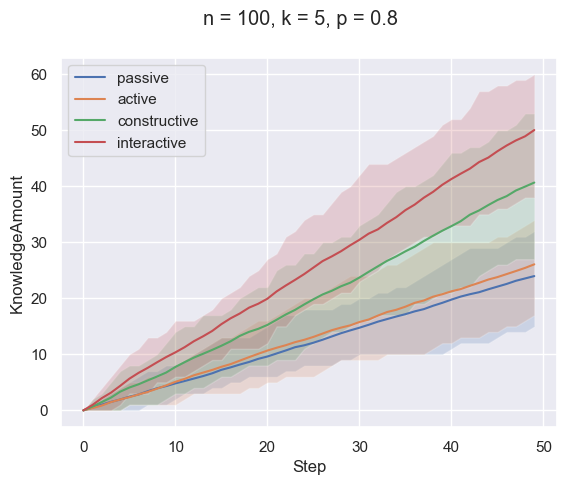

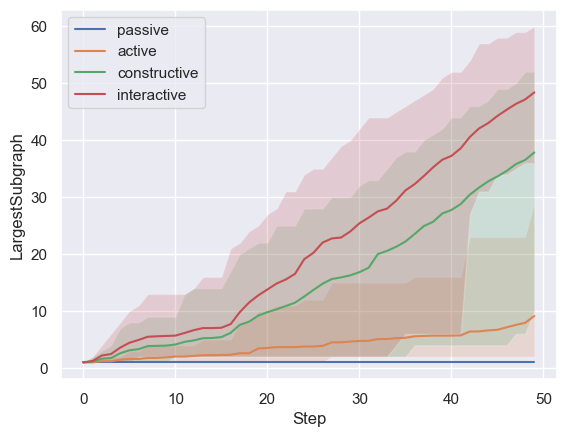

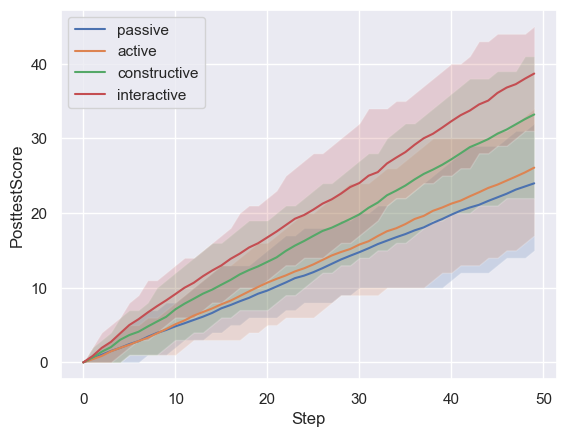

In [ ]:
agents_type = setting_default

for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 0.5)

model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = 100)
df = simulate_ICAP_learning(model, 50, node_skip = 2)
plt.suptitle('n = {}, k = {}, p = {}'.format(num_nodes, k, p))
plot_ICAP_learning(df, agents_type=agents_type, y = 'KnowledgeAmount')
plot_ICAP_learning(df, agents_type=agents_type, y = 'LargestSubgraph')
plot_ICAP_learning(df, agents_type=agents_type, y = 'PosttestScore')

# MultiModal Learning

In this section, we test dynamic modes learners in which each learner has two or more modes of learning which would be changes in the middle of the learning session.
We show that starting with passive and finishing with interactive has a better outcome vs. starting with interactive and finishing with passive. \\
Our hypothesis about this observattion, is based on having a prior knowledge after passive mode. In other words, a learner which starts learning in passive mode and then changes the mode to interactive, has a prior knowledge which they can share with the other interactive learner and it results a better learning outcome.

## Knowledge Graph Effect

/var/folders/m6/7qz9zp8j5cv363wwqc4fmc0m0000gp/T/ipykernel_74639/2028052667.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = plot_df.groupby(by='Step').mean()


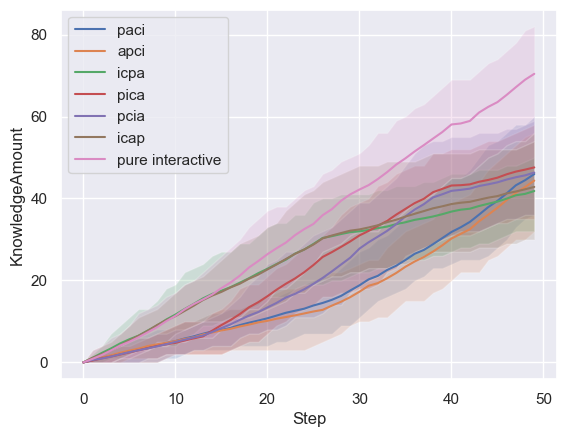

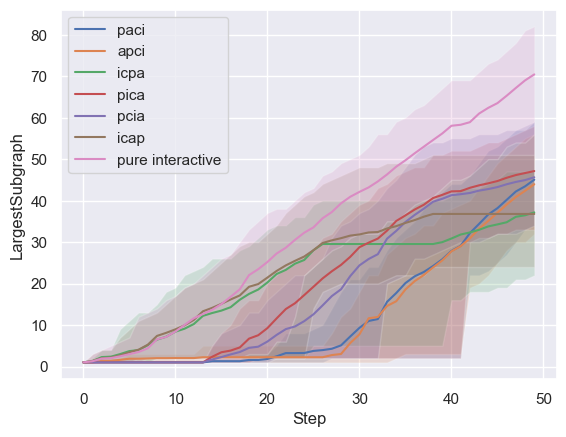

In [ ]:
num_nodes, k, p = 100, 6, 0.8
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)
steps = 50
agents_type = setting_2
for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 1)

model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = 50)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
plot_ICAP_learning(df, agents_type, y = 'KnowledgeAmount')
plot_ICAP_learning(df, agents_type, y = 'LargestSubgraph')

### Graph Density

In [ ]:
num_nodes, k, p = 100, 6, 0.8
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)
steps = 50
agents_type = setting_2
for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 1)

model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = 50)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
print(df.loc[steps - 1, :].groupby(by='GroupType')['KnowledgeAmount'].mean().sort_values())
print(df.loc[steps - 1, :].groupby(by='GroupType')['LargestSubgraph'].mean().sort_values())

GroupType
icap    42.90
icpa    43.02
pcia    44.80
pica    46.50
paci    47.04
apci    48.12
int     68.38
Name: KnowledgeAmount, dtype: float64
GroupType
icap    37.84
icpa    38.86
pcia    43.62
pica    45.76
paci    46.36
apci    47.68
int     68.34
Name: LargestSubgraph, dtype: float64


In [ ]:
num_nodes, k, p = 100, 9, 0.8
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)
steps = 50
agents_type = setting_2
for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 1)

model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = 50)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
print(df.loc[steps - 1, :].groupby(by='GroupType')['KnowledgeAmount'].mean().sort_values())
print(df.loc[steps - 1, :].groupby(by='GroupType')['LargestSubgraph'].mean().sort_values())

GroupType
icpa    45.56
icap    47.14
apci    48.14
paci    50.30
pcia    50.98
pica    52.42
int     76.82
Name: KnowledgeAmount, dtype: float64
GroupType
icpa    42.08
icap    43.00
apci    47.86
paci    50.10
pcia    50.80
pica    52.20
int     76.82
Name: LargestSubgraph, dtype: float64


### Rewiring Probability

In [ ]:
num_nodes, k, p = 100, 6, 0.2
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)
steps = 50
agents_type = setting_2
for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 1)

model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = 50)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
print(df.loc[steps - 1, :].groupby(by='GroupType')['KnowledgeAmount'].mean().sort_values())
print(df.loc[steps - 1, :].groupby(by='GroupType')['LargestSubgraph'].mean().sort_values())

GroupType
apci    45.66
icpa    46.14
icap    46.36
pcia    46.96
paci    47.00
pica    47.38
int     78.46
Name: KnowledgeAmount, dtype: float64
GroupType
icap    38.54
icpa    39.74
apci    41.40
pcia    42.78
pica    44.42
paci    44.94
int     78.44
Name: LargestSubgraph, dtype: float64


In [ ]:
num_nodes, k, p = 100, 6, 0.5
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)
steps = 50
agents_type = setting_2
for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 1)

model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = 50)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
print(df.loc[steps - 1, :].groupby(by='GroupType')['KnowledgeAmount'].mean().sort_values())
print(df.loc[steps - 1, :].groupby(by='GroupType')['LargestSubgraph'].mean().sort_values())

GroupType
pcia    45.84
icpa    46.34
apci    46.88
icap    48.52
paci    49.04
pica    50.12
int     76.56
Name: KnowledgeAmount, dtype: float64
GroupType
icpa    40.42
icap    43.20
pcia    44.80
apci    45.10
paci    47.02
pica    49.50
int     76.56
Name: LargestSubgraph, dtype: float64


In [ ]:
num_nodes, k, p = 100, 6, 0.8
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)
steps = 50
agents_type = setting_2
for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 1)

model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = 50)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
print(df.loc[steps - 1, :].groupby(by='GroupType')['KnowledgeAmount'].mean().sort_values())
print(df.loc[steps - 1, :].groupby(by='GroupType')['LargestSubgraph'].mean().sort_values())

GroupType
icap    42.18
icpa    43.12
pcia    45.66
apci    46.50
pica    46.58
paci    47.18
int     70.24
Name: KnowledgeAmount, dtype: float64
GroupType
icap    35.86
icpa    38.52
pcia    44.92
pica    46.16
apci    46.18
paci    46.60
int     70.24
Name: LargestSubgraph, dtype: float64


### Edge Weights

In [ ]:
num_nodes, k, p = 100, 6, 0.5
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)
steps = 50
agents_type = setting_2
for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 0.2)

model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = 50)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
print(df.loc[steps - 1, :].groupby(by='GroupType')['KnowledgeAmount'].mean().sort_values())
print(df.loc[steps - 1, :].groupby(by='GroupType')['LargestSubgraph'].mean().sort_values())

GroupType
pica    34.50
icap    34.80
icpa    35.06
pcia    35.12
paci    35.18
apci    35.88
int     48.04
Name: KnowledgeAmount, dtype: float64
GroupType
icap    24.42
icpa    24.82
pcia    27.04
paci    27.94
pica    28.30
apci    30.12
int     47.32
Name: LargestSubgraph, dtype: float64


In [ ]:
num_nodes, k, p = 100, 6, 0.5
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)
steps = 50
agents_type = setting_2
for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 0.5)

model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = 50)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
print(df.loc[steps - 1, :].groupby(by='GroupType')['KnowledgeAmount'].mean().sort_values())
print(df.loc[steps - 1, :].groupby(by='GroupType')['LargestSubgraph'].mean().sort_values())

GroupType
icpa    37.70
paci    38.06
apci    38.30
pica    38.58
icap    38.94
pcia    41.40
int     57.82
Name: KnowledgeAmount, dtype: float64
GroupType
icpa    31.28
icap    31.72
apci    35.82
paci    36.36
pica    36.52
pcia    38.36
int     57.74
Name: LargestSubgraph, dtype: float64


In [ ]:
num_nodes, k, p = 100, 6, 0.5
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)
steps = 50
agents_type = setting_2
for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 0.8)

model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = 50)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
print(df.loc[steps - 1, :].groupby(by='GroupType')['KnowledgeAmount'].mean().sort_values())
print(df.loc[steps - 1, :].groupby(by='GroupType')['LargestSubgraph'].mean().sort_values())

GroupType
paci    41.84
icpa    42.92
icap    43.00
apci    43.10
pcia    43.98
pica    46.22
int     66.04
Name: KnowledgeAmount, dtype: float64
GroupType
icap    36.08
icpa    36.52
paci    39.54
apci    41.04
pcia    42.30
pica    45.24
int     65.98
Name: LargestSubgraph, dtype: float64


### Steps

In [ ]:
num_nodes, k, p = 100, 6, 0.5
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)
steps = 20
agents_type = setting_2
for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 0.8)

model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = steps)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
print(df.loc[steps - 1, :].groupby(by='GroupType')['KnowledgeAmount'].mean().sort_values())
print(df.loc[steps - 1, :].groupby(by='GroupType')['LargestSubgraph'].mean().sort_values())

GroupType
pica    14.44
apci    14.78
paci    15.18
icpa    15.78
pcia    15.82
icap    15.88
int     24.24
Name: KnowledgeAmount, dtype: float64
GroupType
icap     8.94
apci     9.04
icpa    10.30
pica    11.06
pcia    12.10
paci    12.70
int     23.90
Name: LargestSubgraph, dtype: float64


In [ ]:
num_nodes, k, p = 100, 6, 0.5
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)
steps = 50
agents_type = setting_2
for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 0.8)

model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = steps)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
print(df.loc[steps - 1, :].groupby(by='GroupType')['KnowledgeAmount'].mean().sort_values())
print(df.loc[steps - 1, :].groupby(by='GroupType')['LargestSubgraph'].mean().sort_values())

GroupType
icap    42.44
icpa    42.92
apci    43.14
paci    43.28
pcia    44.10
pica    44.64
int     66.10
Name: KnowledgeAmount, dtype: float64
GroupType
icap    35.70
icpa    36.56
paci    40.96
apci    41.08
pcia    42.36
pica    42.60
int     66.10
Name: LargestSubgraph, dtype: float64


In [ ]:
num_nodes, k, p = 100, 6, 0.5
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)
steps = 80
agents_type = setting_2
for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 0.8)

model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = steps)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
print(df.loc[steps - 1, :].groupby(by='GroupType')['KnowledgeAmount'].mean().sort_values())
print(df.loc[steps - 1, :].groupby(by='GroupType')['LargestSubgraph'].mean().sort_values())

GroupType
icap    63.80
icpa    64.20
pica    68.92
pcia    69.08
apci    70.24
paci    70.56
int     90.24
Name: KnowledgeAmount, dtype: float64
GroupType
icap    57.00
icpa    59.52
pica    68.80
pcia    68.88
apci    70.00
paci    70.50
int     90.24
Name: LargestSubgraph, dtype: float64


### node_skip

In [ ]:
num_nodes, k, p = 100, 6, 0.5
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)
steps = 50
agents_type = setting_2
for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 0.8)

model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = steps)
df = simulate_ICAP_learning(model, steps, node_skip = 1)
print(df.loc[steps - 1, :].groupby(by='GroupType')['KnowledgeAmount'].mean().sort_values())
print(df.loc[steps - 1, :].groupby(by='GroupType')['LargestSubgraph'].mean().sort_values())

GroupType
pcia    40.18
icpa    40.72
icap    41.14
apci    41.48
pica    41.50
paci    42.54
int     57.76
Name: KnowledgeAmount, dtype: float64
GroupType
icap    36.04
icpa    36.14
pcia    38.76
pica    40.18
apci    40.74
paci    41.98
int     57.74
Name: LargestSubgraph, dtype: float64


In [ ]:
num_nodes, k, p = 100, 6, 0.5
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)
steps = 50
agents_type = setting_2
for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 0.8)

model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = steps)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
print(df.loc[steps - 1, :].groupby(by='GroupType')['KnowledgeAmount'].mean().sort_values())
print(df.loc[steps - 1, :].groupby(by='GroupType')['LargestSubgraph'].mean().sort_values())

GroupType
icap    40.96
icpa    41.76
pica    43.14
paci    43.18
apci    43.32
pcia    43.42
int     67.38
Name: KnowledgeAmount, dtype: float64
GroupType
icap    33.26
icpa    37.40
pica    41.00
paci    41.46
apci    41.68
pcia    41.68
int     67.26
Name: LargestSubgraph, dtype: float64


In [ ]:
num_nodes, k, p = 100, 6, 0.5
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)
steps = 50
agents_type = setting_2
for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 0.8)

model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = steps)
df = simulate_ICAP_learning(model, steps, node_skip = 3)
print(df.loc[steps - 1, :].groupby(by='GroupType')['KnowledgeAmount'].mean().sort_values())
print(df.loc[steps - 1, :].groupby(by='GroupType')['LargestSubgraph'].mean().sort_values())

GroupType
icap    40.86
icpa    41.28
pcia    43.48
apci    44.32
paci    44.54
pica    45.16
int     63.68
Name: KnowledgeAmount, dtype: float64
GroupType
icap    35.00
icpa    35.30
pcia    42.22
apci    43.52
paci    44.04
pica    44.58
int     63.62
Name: LargestSubgraph, dtype: float64


## Flipped Classroom

In [ ]:
num_nodes, k, p = 80, 3, 0.8
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)

for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 0.8)

/var/folders/m6/7qz9zp8j5cv363wwqc4fmc0m0000gp/T/ipykernel_74639/2772763786.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = plot_df.groupby(by='Step').mean()


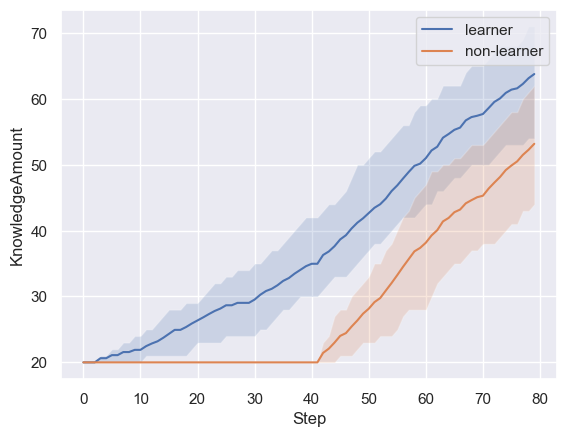

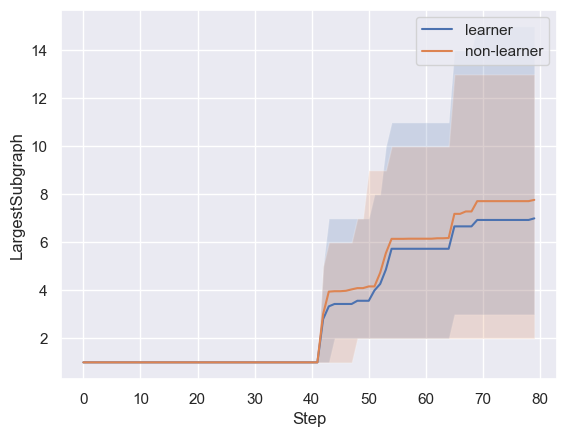

GroupType
learner        63.766667
non-learner    53.176471
Name: KnowledgeAmount, dtype: float64

In [ ]:
fc_setting_1 = {
    "learner": {
        "name": 'learner',
        "order": {
            "passive": 0.5,
            "interactive": 1
        },
        "count": 30,
    },"non-learner": {
        "name": 'non-learner',
        "order": {
            "non-learner": 0.5,
            "interactive": 1
        },
        "count": 170
    }
}
steps = 80

model = ICAPModel(knowledge_graph, agents_type=fc_setting_1, fc=True, max_time=80, nodes_known_before=20)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
plot_ICAP_learning(df, fc_setting_1, y = 'KnowledgeAmount')
plot_ICAP_learning(df, fc_setting_1, y = 'LargestSubgraph')
df.loc[steps-1,:].groupby(by='GroupType')['KnowledgeAmount'].mean()

/var/folders/m6/7qz9zp8j5cv363wwqc4fmc0m0000gp/T/ipykernel_74639/2772763786.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = plot_df.groupby(by='Step').mean()


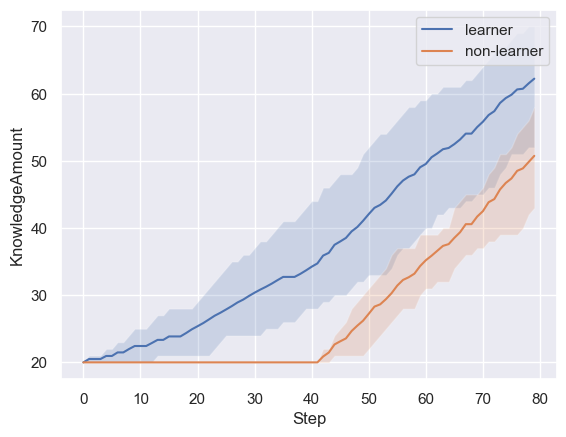

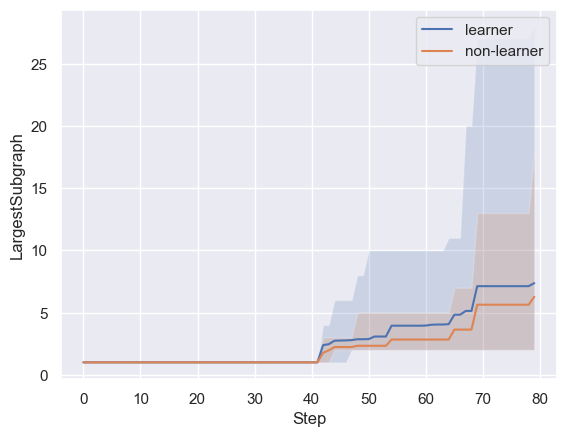

GroupType
learner        62.217647
non-learner    50.733333
Name: KnowledgeAmount, dtype: float64

In [ ]:
fc_setting_2 = {
    "learner": {
        "name": 'learner',
        "order": {
            "passive": 0.5,
            "interactive": 1
        },
        "count": 170,
    },"non-learner": {
        "name": 'non-learner',
        "order": {
            "non-learner": 0.5,
            "interactive": 1
        },
        "count": 30
    }
}


model = ICAPModel(knowledge_graph, agents_type=fc_setting_2, fc=True, max_time=80, nodes_known_before=20)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
plot_ICAP_learning(df, fc_setting_2, y = 'KnowledgeAmount')
plot_ICAP_learning(df, fc_setting_2, y = 'LargestSubgraph')
df.loc[steps-1,:].groupby(by='GroupType')['KnowledgeAmount'].mean()

## Pairing Strategies

### Constant vs. Online pairing

In [ ]:
num_nodes, k, p = 100, 6, 0.8

knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)

for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 1)

/var/folders/m6/7qz9zp8j5cv363wwqc4fmc0m0000gp/T/ipykernel_74639/2028052667.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = plot_df.groupby(by='Step').mean()


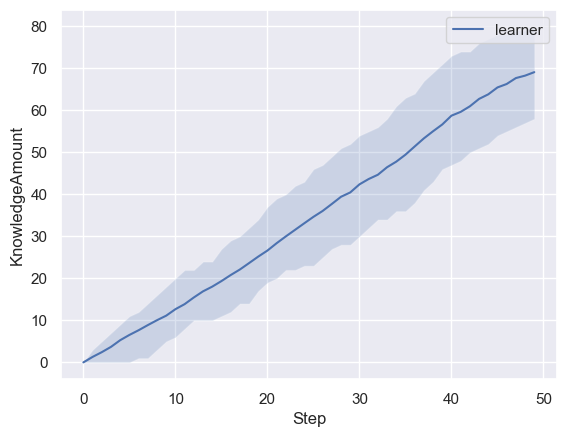

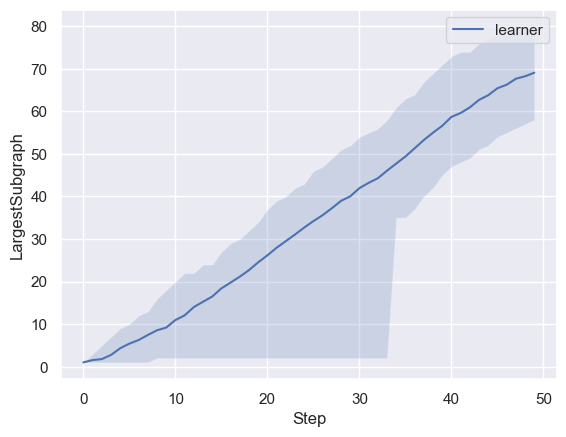

69.1
69.1


In [ ]:
ps_setting_1 = {
    "learner": {
        "name": 'learner',
        "order": {
            "interactive": 1
        },
        "count": 100,
    }
}
steps = 50

model = ICAPModel(knowledge_graph, agents_type=ps_setting_1, ps=True)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
plot_ICAP_learning(df, ps_setting_1, y = 'KnowledgeAmount')
plot_ICAP_learning(df, ps_setting_1, y = 'LargestSubgraph')

print(df.loc[steps - 1,:]['KnowledgeAmount'].mean())
print(df.loc[steps - 1,:]['LargestSubgraph'].mean())

/var/folders/m6/7qz9zp8j5cv363wwqc4fmc0m0000gp/T/ipykernel_74639/2028052667.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = plot_df.groupby(by='Step').mean()


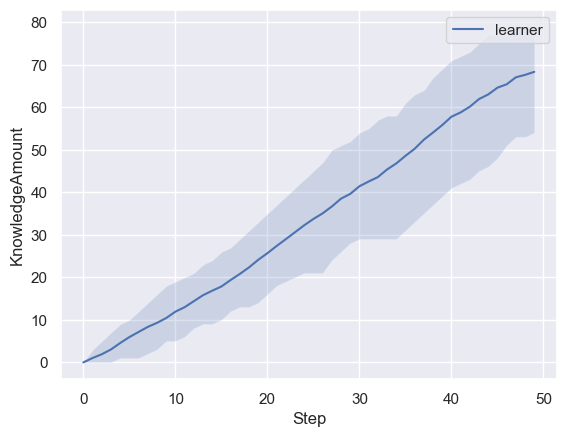

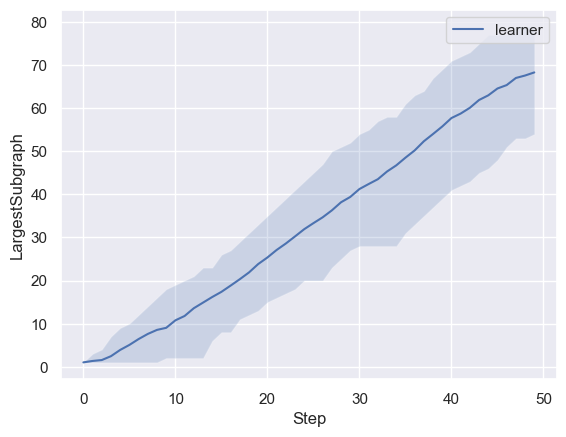

68.31
68.31


In [ ]:
model = ICAPModel(knowledge_graph, agents_type=ps_setting_1, ps=False)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
plot_ICAP_learning(df, ps_setting_1, y = 'KnowledgeAmount')
plot_ICAP_learning(df, ps_setting_1, y = 'LargestSubgraph')
print(df.loc[steps - 1,:]['KnowledgeAmount'].mean())
print(df.loc[steps - 1,:]['LargestSubgraph'].mean())

### Best Partner

/var/folders/m6/7qz9zp8j5cv363wwqc4fmc0m0000gp/T/ipykernel_75405/3734458362.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = plot_df.groupby(by='Step').mean()


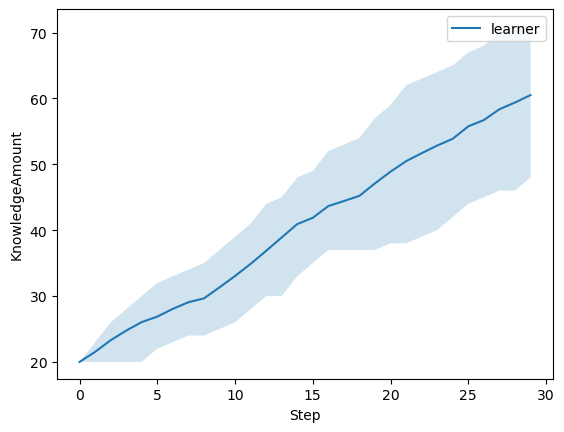

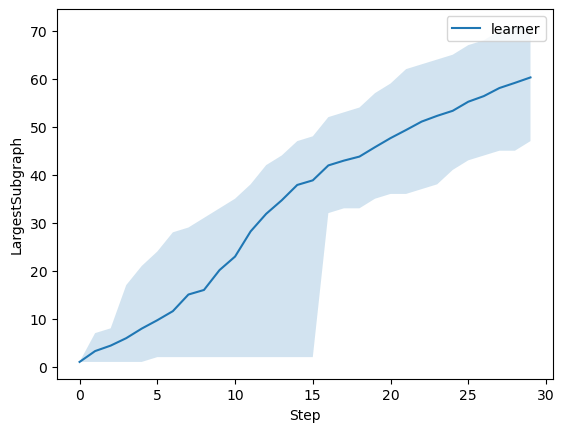

60.5
60.27


In [ ]:
bp_setting_1 = {
    "learner": {
        "name": 'learner',
        "order": {
            "interactive": 1
        },
        "count": 100,
    }
}
steps = 30

model = ICAPModel(knowledge_graph, agents_type=bp_setting_1, nodes_known_before=20)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
plot_ICAP_learning(df, bp_setting_1, y = 'KnowledgeAmount')
plot_ICAP_learning(df, bp_setting_1, y = 'LargestSubgraph')

print(df.loc[steps - 1,:]['KnowledgeAmount'].mean())
print(df.loc[steps - 1,:]['LargestSubgraph'].mean())

/var/folders/m6/7qz9zp8j5cv363wwqc4fmc0m0000gp/T/ipykernel_75405/3734458362.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = plot_df.groupby(by='Step').mean()


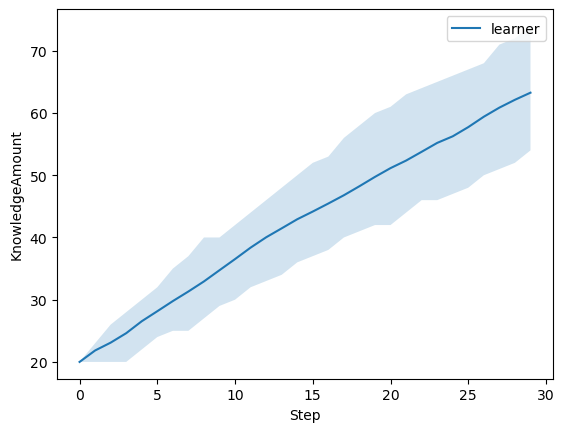

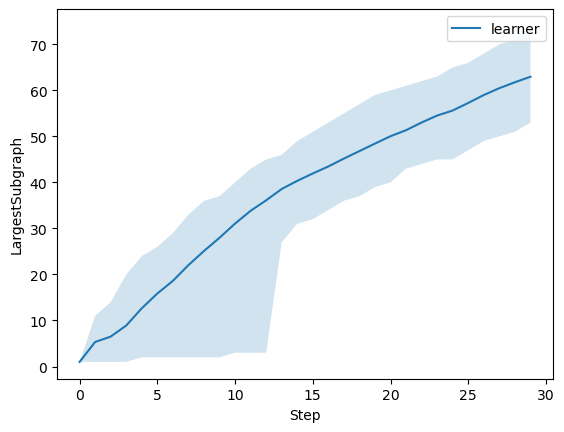

63.27
62.96


In [ ]:
bp_setting_1 = {
    "learner": {
        "name": 'learner',
        "order": {
            "interactive": 1
        },
        "count": 100,
    }
}
steps = 30

model = ICAPModel(knowledge_graph, agents_type=bp_setting_1, nodes_known_before=20, different_prior_knowledge=True)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
plot_ICAP_learning(df, bp_setting_1, y = 'KnowledgeAmount')
plot_ICAP_learning(df, bp_setting_1, y = 'LargestSubgraph')

print(df.loc[steps - 1,:]['KnowledgeAmount'].mean())
print(df.loc[steps - 1,:]['LargestSubgraph'].mean())

/var/folders/m6/7qz9zp8j5cv363wwqc4fmc0m0000gp/T/ipykernel_75405/3734458362.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = plot_df.groupby(by='Step').mean()


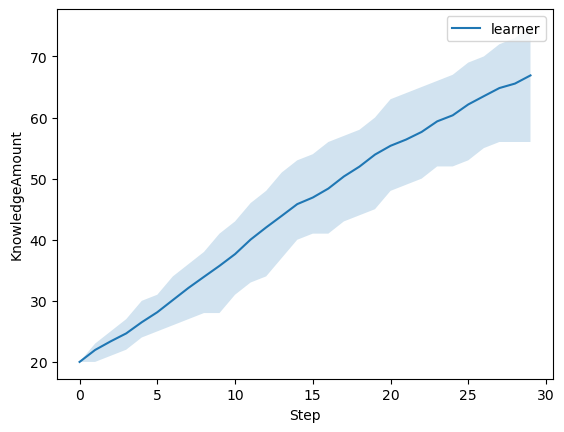

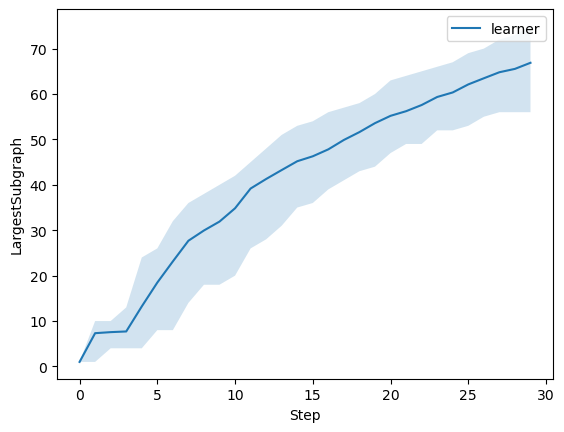

66.9
66.88


In [ ]:
bp_setting_1 = {
    "learner": {
        "name": 'learner',
        "order": {
            "interactive": 1
        },
        "count": 100,
    }
}
steps = 30

model = ICAPModel(knowledge_graph, agents_type=bp_setting_1, nodes_known_before=20, complement_knowledge=True)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
plot_ICAP_learning(df, bp_setting_1, y = 'KnowledgeAmount')
plot_ICAP_learning(df, bp_setting_1, y = 'LargestSubgraph')

print(df.loc[steps - 1,:]['KnowledgeAmount'].mean())
print(df.loc[steps - 1,:]['LargestSubgraph'].mean())

In [ ]:
bp_setting_1 = {
    "learner": {
        "name": 'learner',
        "order": {
            "interactive": 1
        },
        "count": 100,
    }
}
bp2_ka_res, bp1_ka_res, bp0_ka_res = [], [], []
bp2_ls_res, bp1_ls_res, bp0_ls_res = [], [], []
bp2_std, bp1_std, bp0_std = [], [], []
steps = 50
prior_knowledge=30
for _ in range(20):
  model = ICAPModel(knowledge_graph, agents_type=bp_setting_1, nodes_known_before=prior_knowledge)
  df = simulate_ICAP_learning(model, steps, node_skip = 2)
  bp0_ka_res.append(df.loc[steps - 1,:]['KnowledgeAmount'].mean())
  bp0_std.append(df.loc[steps - 1,:]['KnowledgeAmount'].std())
  bp0_ls_res.append(df.loc[steps - 1,:]['LargestSubgraph'].mean())
  
  model = ICAPModel(knowledge_graph, agents_type=ps_setting_1, different_prior_knowledge=True, nodes_known_before=prior_knowledge)
  df = simulate_ICAP_learning(model, steps, node_skip = 2)
  bp1_ka_res.append(df.loc[steps - 1,:]['KnowledgeAmount'].mean())
  bp1_std.append(df.loc[steps - 1,:]['KnowledgeAmount'].std())
  bp1_ls_res.append(df.loc[steps - 1,:]['LargestSubgraph'].mean())

  model = ICAPModel(knowledge_graph, agents_type=bp_setting_1, complement_knowledge=True, nodes_known_before=prior_knowledge)
  df = simulate_ICAP_learning(model, steps, node_skip = 2)
  bp2_ka_res.append(df.loc[steps - 1,:]['KnowledgeAmount'].mean())
  bp2_std.append(df.loc[steps - 1,:]['KnowledgeAmount'].std())
  bp2_ls_res.append(df.loc[steps - 1,:]['LargestSubgraph'].mean())

# Robustness test

In [ ]:
agents_type=setting_default

## Number of Nodes

Text(0, 0.5, 'Final Knowledge amount on average')

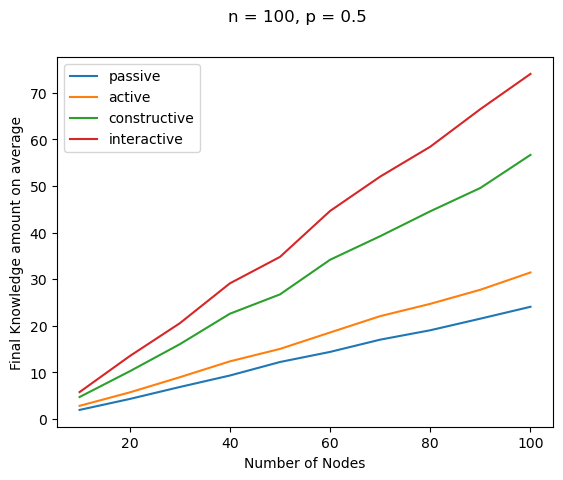

In [ ]:
from numpy.core.fromnumeric import mean
simulation_data = pd.DataFrame(columns=['Time','KnowledgeAmount','LargestSubgraph','GroupType', 'NumNodes'])
for _ in range(2):
    for num_nodes in range(10, 101, 10):
        G = nx.watts_strogatz_graph(num_nodes, k, p)
        for (u, v) in G.edges():
            G.edges[u,v]['weight'] = random.random()
        model = ICAPModel(G, agents_type=agents_type, max_time=num_nodes / 2)
        df = simulate_ICAP_learning(model, num_nodes // 2, node_skip = 2)
        for agent_type in agents_type.keys():
            plot_df = df.loc[(num_nodes - 1) // 2, : ]
            plot_df = plot_df[plot_df.GroupType == agent_type]
            mean_df = plot_df.mean(numeric_only=True, axis=0)
            mean_df['GroupType'] = agent_type
            mean_df['KnowledgeAmount'] = mean_df['KnowledgeAmount']
            mean_df['NumNodes'] = num_nodes
            simulation_data.loc[len(simulation_data)] = mean_df
for agent_type in agents_type.keys():
    plot_df = simulation_data[simulation_data.GroupType == agent_type]
    mean_df = plot_df.groupby('NumNodes')[['Time','KnowledgeAmount', 'LargestSubgraph']].mean()
    plt.plot(mean_df.KnowledgeAmount)

plt.legend(agents_type.keys())
plt.suptitle(f'n = {num_nodes}, p = {p}')
plt.xlabel('Number of Nodes')
plt.ylabel('Final Knowledge amount on average')

## Iterating through different `k`s 
In this part, we try to test different graphs as `k` is increasing. The `k` variable indicates the number nodes in which each node is connected to.

Text(0, 0.5, 'Final Knowledge amount on average')

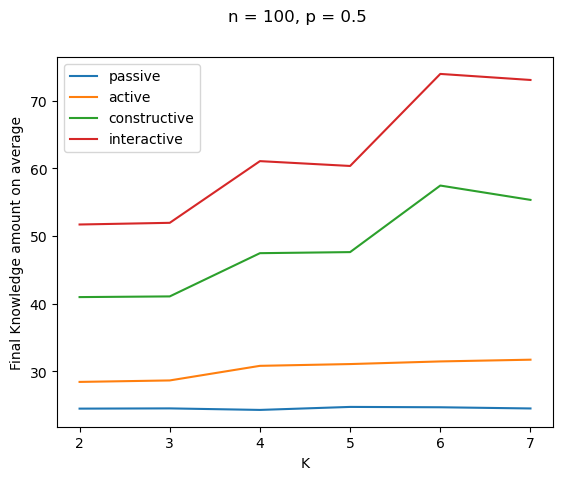

In [ ]:
simulation_data = pd.DataFrame(columns=['Time','KnowledgeAmount','LargestSubgraph','GroupType', 'K'])
for _ in range(10):
    for k in range(2, 10, 2):
        G = nx.watts_strogatz_graph(num_nodes, k, p)
        for (u, v) in G.edges():
            G.edges[u,v]['weight'] = random.random()
        model = ICAPModel(G, agents_type=agents_type, max_time = 100)
        df = simulate_ICAP_learning(model, 50, node_skip = 2)
        for agent_type in agents_type.keys():
            plot_df = df.loc[49, : ]
            plot_df = plot_df[plot_df.GroupType == agent_type]
            mean_df = plot_df.mean(numeric_only=True, axis=0)
            mean_df['GroupType'] = agent_type
            mean_df['K'] = k
            simulation_data.loc[len(simulation_data)] = mean_df

for agent_type in agents_type.keys():
    plot_df = simulation_data[simulation_data.GroupType == agent_type]
    mean_df = plot_df.groupby('K')[['Time','KnowledgeAmount', 'LargestSubgraph']].mean()
    plt.plot(mean_df.KnowledgeAmount)

plt.legend(agents_type.keys())
plt.suptitle(f'n = {num_nodes}, p = {p}')
plt.xlabel('K')
plt.ylabel('Final Knowledge amount on average')

## `node_skip`
Iteration through node_skips. The simulation result does not show any substantial infulence of this variable.

Text(0, 0.5, 'Final Knowledge amount on average')

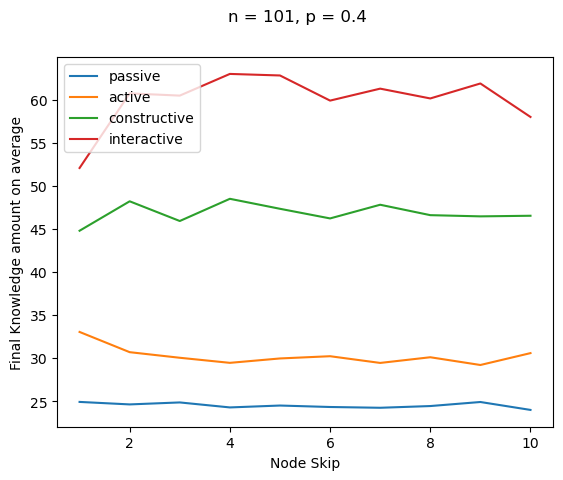

In [ ]:
num_nodes, k, p = 101, 5, 0.4

simulation_data = pd.DataFrame(columns=['Time','KnowledgeAmount','LargestSubgraph','GroupType', 'NodeSkip'])
node_skips = range(1, 11)
for _ in range(2):
    for ns in node_skips:
        G = nx.watts_strogatz_graph(num_nodes, k, p)
        for i in G.nodes():
            G.add_node(i)
        for (u, v) in G.edges():
            G.edges[u,v]['weight'] = random.random()
        model = ICAPModel(G, agents_type=agents_type)
        df = simulate_ICAP_learning(model, 50, node_skip = ns)
        for agent_type in agents_type.keys():
            plot_df = df.loc[49, : ]
            plot_df = plot_df[plot_df.GroupType == agent_type]
            mean_df = plot_df.mean(numeric_only=True, axis=0)
            mean_df['GroupType'] = agent_type
            mean_df['NodeSkip'] = ns
            simulation_data.loc[len(simulation_data)] = mean_df

for agent_type in agents_type.keys():
    plot_df = simulation_data[simulation_data.GroupType == agent_type]
    mean_df = plot_df.groupby('NodeSkip')[['Time','KnowledgeAmount', 'LargestSubgraph']].mean()
    plt.plot(mean_df.KnowledgeAmount)

plt.legend(agents_type.keys())
plt.suptitle(f'n = {num_nodes}, p = {p}')
plt.xlabel('Node Skip')
plt.ylabel('Final Knowledge amount on average')

## Edge Weights 
In this part, we try to test different edge weights.

### MaxRange

The simulation here, variates the `MaxRange`. Each edge weight lies in (0, `MaxRange`). As shown in the results plot, The more the `MaxRange` is, The more deviation between modes' outcomes is. 

Text(0, 0.5, 'Final Knowledge amount on average')

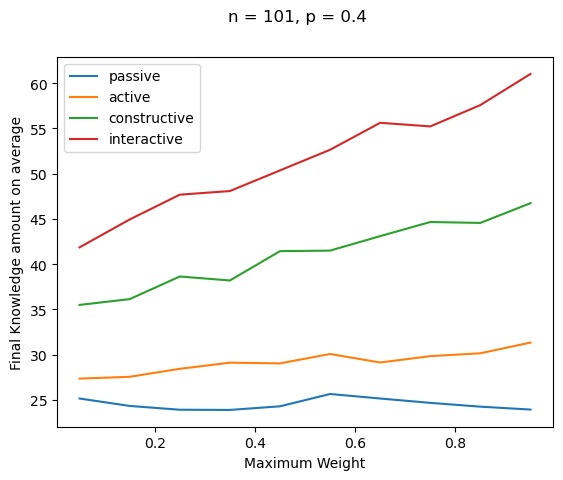

In [ ]:
simulation_data = pd.DataFrame(columns=['Time','KnowledgeAmount','LargestSubgraph','GroupType', 'MaxRange'])

weights = [(0, x / 100) for x in range(5, 100, 10)]
for _ in range(1):
    for _range in weights:
        G = nx.watts_strogatz_graph(num_nodes, k, p)
        for (u, v) in G.edges():
            G.edges[u,v]['weight'] = random.uniform(*_range)
        model = ICAPModel(G, agents_type=agents_type)
        df = simulate_ICAP_learning(model, 50, node_skip = 2)
        for agent_type in agents_type.keys():
            plot_df = df.loc[49, : ]
            plot_df = plot_df[plot_df.GroupType == agent_type]
            mean_df = plot_df.mean(numeric_only=True, axis=0)
            mean_df['GroupType'] = agent_type
            mean_df['MaxRange'] = _range[1]
            simulation_data.loc[len(simulation_data)] = mean_df

for agent_type in agents_type.keys():
    plot_df = simulation_data[simulation_data.GroupType == agent_type]
    mean_df = plot_df.groupby('MaxRange')[['Time','KnowledgeAmount', 'LargestSubgraph']].mean()
    plt.plot(mean_df.KnowledgeAmount)

plt.legend(agents_type.keys())
plt.suptitle(f'n = {num_nodes}, p = {p}')
plt.xlabel('Maximum Weight')
plt.ylabel('Final Knowledge amount on average')

### MinRange

Text(0, 0.5, 'Final Knowledge amount on average')

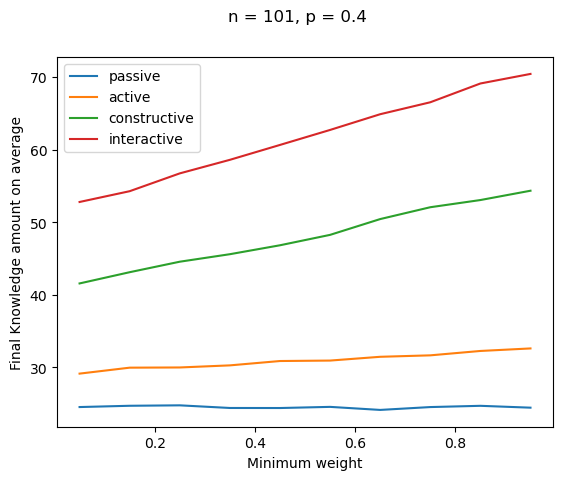

In [ ]:
simulation_data = pd.DataFrame(columns=['Time','KnowledgeAmount','LargestSubgraph','GroupType', 'MinRange'])

weights = [(x/100, 0.5) for x in range(5, 100, 10)]
for _ in range(10):
    for _range in weights:
        G = nx.watts_strogatz_graph(num_nodes, k, p)
        for (u, v) in G.edges():
            G.edges[u,v]['weight'] = random.uniform(*_range)
        model = ICAPModel(G, agents_type=agents_type)
        df = simulate_ICAP_learning(model, 50, node_skip = 2)
        for agent_type in agents_type.keys():
            plot_df = df.loc[49, : ]
            plot_df = plot_df[plot_df.GroupType == agent_type]
            mean_df = plot_df.mean(numeric_only=True, axis=0)
            mean_df['GroupType'] = agent_type
            mean_df['MinRange'] = _range[0]
            simulation_data.loc[len(simulation_data)] = mean_df

for agent_type in agents_type.keys():
    plot_df = simulation_data[simulation_data.GroupType == agent_type]
    mean_df = plot_df.groupby('MinRange')[['Time','KnowledgeAmount', 'LargestSubgraph']].mean()
    plt.plot(mean_df.KnowledgeAmount)

plt.legend(agents_type.keys())
plt.suptitle(f'n = {num_nodes}, p = {p}')
plt.xlabel('Minimum weight')
plt.ylabel('Final Knowledge amount on average')

# Prior Knowledge Effect

In this section we try to replicate the original ICAP paper results, in which each type of learner has a prior knowledge amount of 50%.
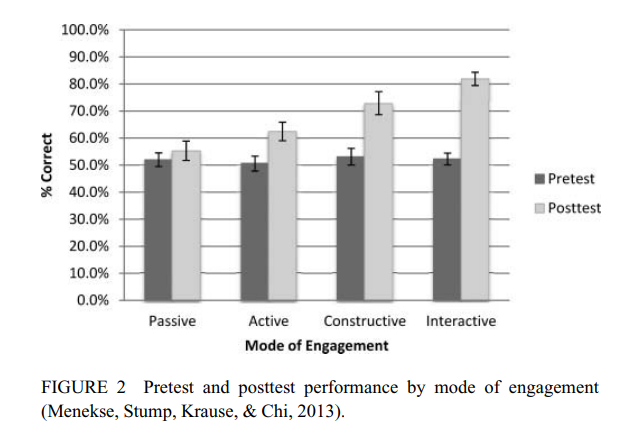

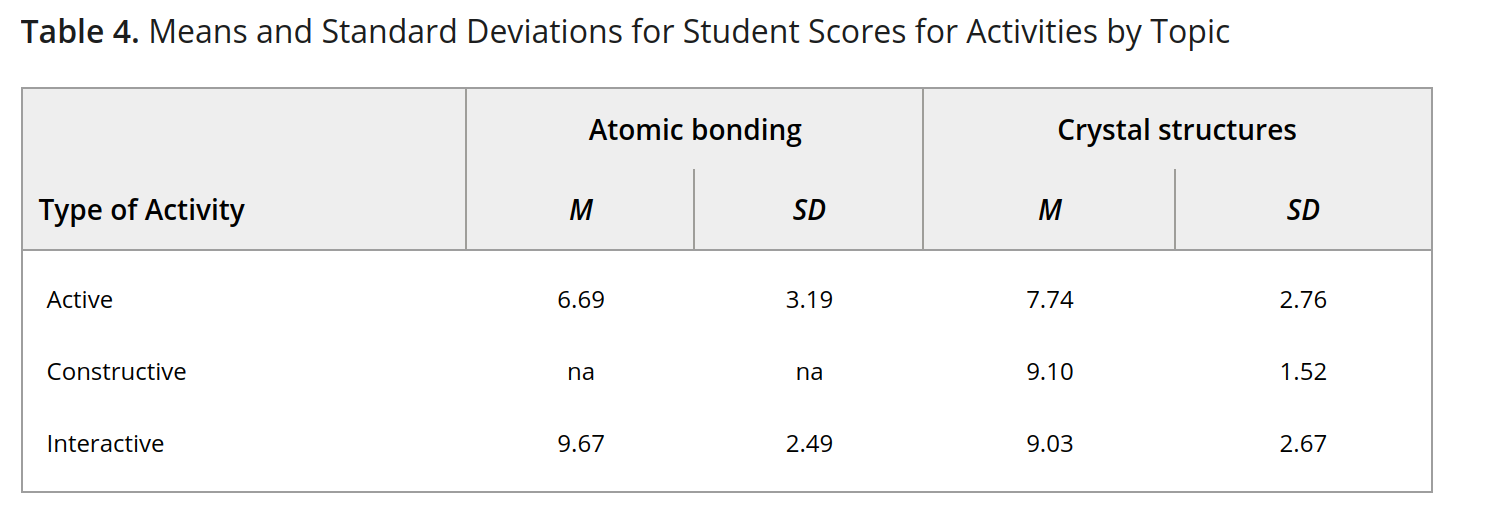

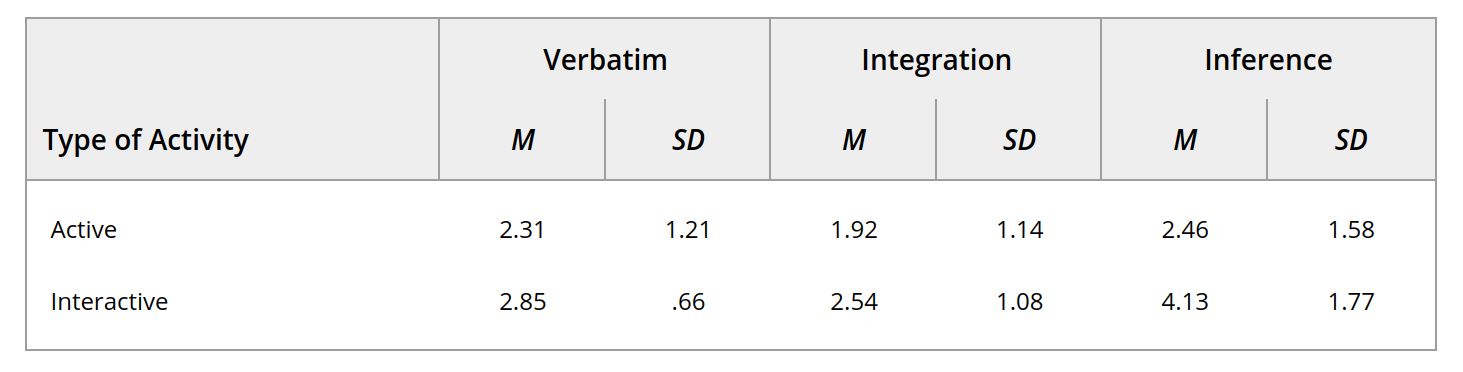

In [ ]:
num_nodes, k, p = 200, 4, 0.8
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)

prior_setting_1 = {
    "pas": {
        "name": 'pas',
        "order": {
            "passive": 1,
        },
        "count": 50,
    },"act": {
        "name": 'act',
        "order": {
            "active": 1,
        },
        "count": 50,
    },"cons": {
        "name": 'cons',
        "order": {
            "constructive": 1,
        },
        "count": 50,
    },"inter": {
        "name": 'inter',
        "order": {
            "interactive": 1,
        },
        "count": 50,
    }
}

time_per_step_dict = {'passive': 1, 
                      'active': 1, 
                      'constructive': 1, 
                      'interactive': 1}

/var/folders/m6/7qz9zp8j5cv363wwqc4fmc0m0000gp/T/ipykernel_74639/3580326478.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = plot_df.groupby(by='Step').mean()


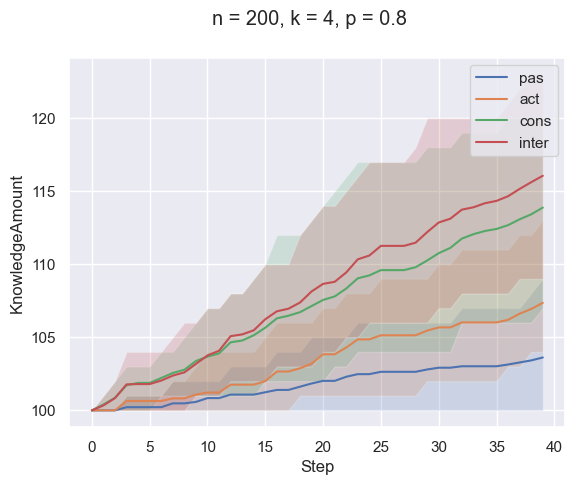

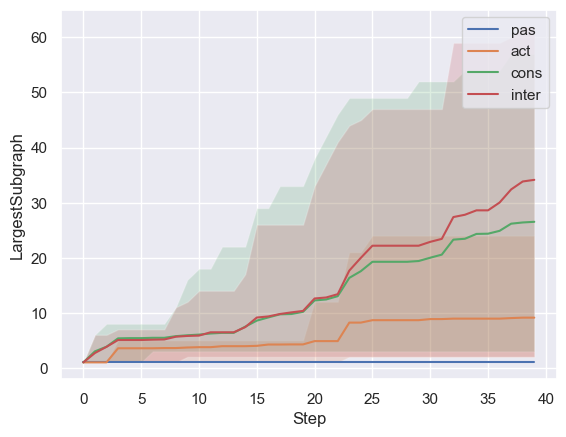

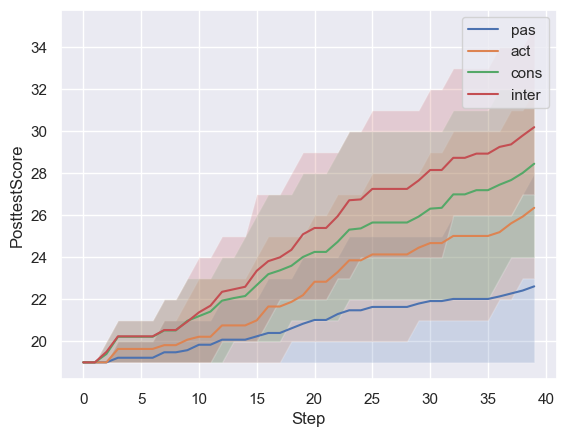

In [ ]:
for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 0.7)
steps = 40
model = ICAPModel(knowledge_graph, agents_type=prior_setting_1, nodes_known_before=100)
df = simulate_ICAP_learning(model, steps, node_skip = 2)
df['KnowledgeAmount'] = df['KnowledgeAmount'] 

plt.suptitle('n = {}, k = {}, p = {}'.format(num_nodes, k, p))
plot_ICAP_learning(df, agents_type=prior_setting_1, y = 'KnowledgeAmount')
plot_ICAP_learning(df, agents_type=prior_setting_1, y = 'LargestSubgraph')
plot_ICAP_learning(df, agents_type=prior_setting_1, y = 'PosttestScore')


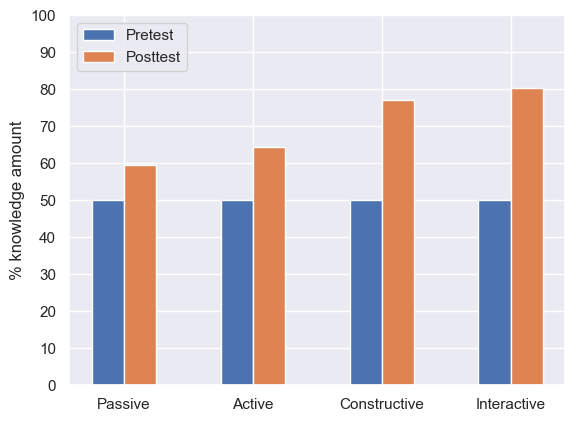

In [ ]:
pretest_scores = df.groupby(by='GroupType')['KnowledgeAmount'].min().sort_values() / 2
posttest_scores = df.loc[steps - 1].groupby(by='GroupType')['KnowledgeAmount'].mean().sort_values() / 2
bar_width = 0.25
plt.bar(np.arange(pretest_scores.size), pretest_scores, width=bar_width, label='Pretest')
plt.bar(np.arange(pretest_scores.size) + bar_width, posttest_scores, width=bar_width, label='Posttest')
plt.xticks([r + bar_width / 2 for r in range(len(pretest_scores))],
        ['Passive', 'Active', 'Constructive', 'Interactive'])
plt.yticks(np.arange(0, 101, 10))
plt.ylim(0, 100)
plt.legend(loc='upper left')
plt.ylabel('% knowledge amount')
plt.savefig('knowledge_amount_gap.png')

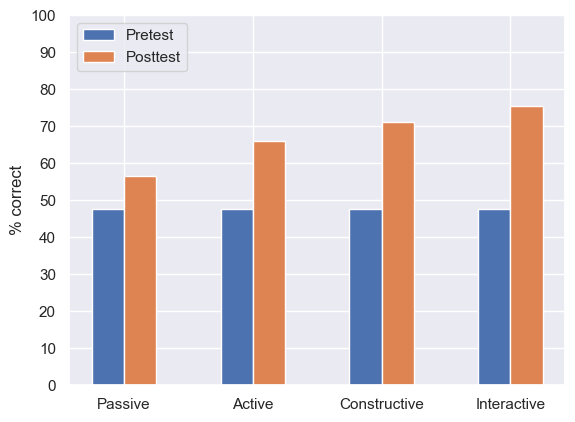

In [ ]:
pretest_scores = df.groupby(by='GroupType')['PosttestScore'].min().sort_values() * (100 / steps)
posttest_scores = df.loc[steps - 1].groupby(by='GroupType')['PosttestScore'].mean().sort_values() * (100 / steps)
bar_width = 0.25
plt.bar(np.arange(pretest_scores.size), pretest_scores, width=bar_width, label='Pretest')
plt.bar(np.arange(pretest_scores.size) + bar_width, posttest_scores, width=bar_width, label='Posttest')
plt.xticks([r + bar_width / 2 for r in range(len(pretest_scores))],
        ['Passive', 'Active', 'Constructive', 'Interactive'])
plt.yticks(np.arange(0, 101, 10))
plt.ylim(0, 100)
plt.legend(loc='upper left')
plt.ylabel('% correct')
plt.savefig('meneske_sim.png')

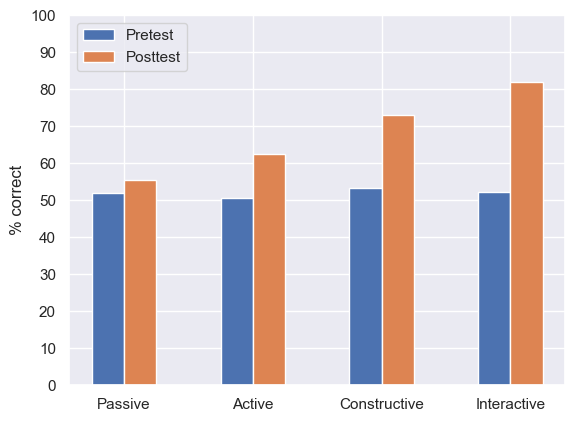

In [ ]:
bar_width = 0.25
plt.bar(np.arange(pretest_scores.size), [51.99, 50.58, 53.14, 52.28], width=bar_width, label='Pretest')
plt.bar(np.arange(pretest_scores.size) + bar_width, [55.33, 62.45, 72.94, 81.91], width=bar_width, label='Posttest')
plt.xticks([r + bar_width / 2 for r in range(len(pretest_scores))],
        ['Passive', 'Active', 'Constructive', 'Interactive'])
plt.yticks(np.arange(0, 101, 10))
plt.ylim(0, 100)
plt.legend(loc='upper left')
plt.ylabel('% correct')
plt.savefig('meneske_lab.png')

In [ ]:
time_per_step_dict = {'passive': 1, 
                      'active': 1.1, 
                      'constructive': 1.5, 
                      'interactive': 1.5}

model = ICAPModel(knowledge_graph, agents_type=prior_setting_1, 
                         nodes_known_before=25, time_per_step_dict=time_per_step_dict, max_time=50)
df = simulate_ICAP_learning(model, 50, node_skip = 1)
plt.suptitle('n = {}, k = {}, p = {}'.format(num_nodes, k, p))
plot_ICAP_learning(df, y = 'KnowledgeAmount')
plot_ICAP_learning(df, y = 'LargestSubgraph')

### Flipped Classroom

/var/folders/m6/7qz9zp8j5cv363wwqc4fmc0m0000gp/T/ipykernel_74639/2028052667.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = plot_df.groupby(by='Step').mean()


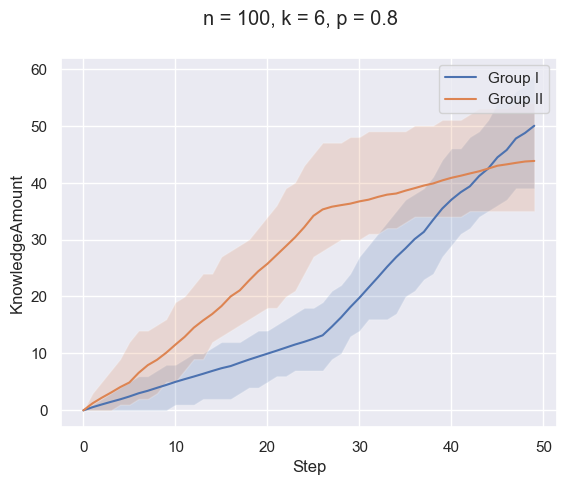

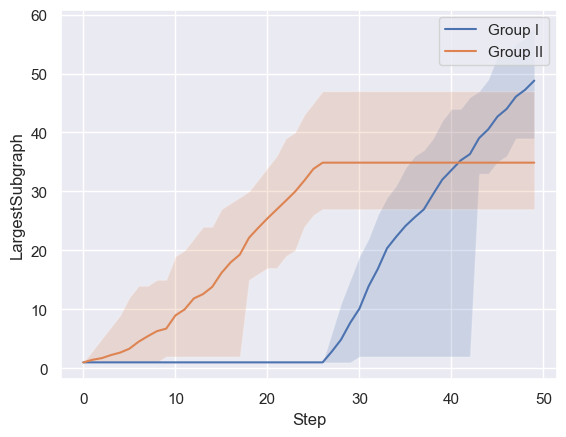

In [ ]:
for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 1)

prior_setting_2 = {
    "Group I": {
        "name": 'Group I',
        "order": {
            "passive": 0.5,
            "interactive": 1
        },
        "count": 50,
    },"Group II": {
        "name": 'Group II',
        "order": {
            "interactive": 0.5,
            "passive": 1
        },
        "count": 50
    }
}

model = ICAPModel(knowledge_graph, agents_type=prior_setting_2, nodes_known_before=0, max_time=50)
df = simulate_ICAP_learning(model, 50, node_skip = 2)
plt.suptitle('n = {}, k = {}, p = {}'.format(num_nodes, k, p))
plot_ICAP_learning(df, prior_setting_2, y = 'KnowledgeAmount')
plot_ICAP_learning(df, prior_setting_2, y = 'LargestSubgraph')

# Time Equivalence Ratio

## Interactive / Constructive

In [ ]:
num_nodes, k, p = 100, 5, 0.8
knowledge_graph = nx.watts_strogatz_graph(num_nodes, k, p)
num_agents_by_type = {
                      'constructive': 50,
                      'interactive': 50
                      }
time_per_step_dict = {
                      'constructive': 1, 
                      'interactive': 1
                      }
for (u, v) in knowledge_graph.edges():
  knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 1)

In [ ]:
def simulate_ICAP_learning_time_ratios(model, num_steps = 50, node_skip = 1):
  for i in range(num_steps):
    model.step(node_skip)

  agents_df = model.datacollector.get_agent_vars_dataframe()
  agents_df['KnowledgeAmount'] = [len(x) for x in agents_df.Knowledge]
  agents_df['LargestSubgraph'] = [len(max(nx.connected_components(nx.Graph(x)))) if x != [] else 1 for x in agents_df.KnowledgeLinks]

  return agents_df

/var/folders/m6/7qz9zp8j5cv363wwqc4fmc0m0000gp/T/ipykernel_74639/3580326478.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = plot_df.groupby(by='Step').mean()


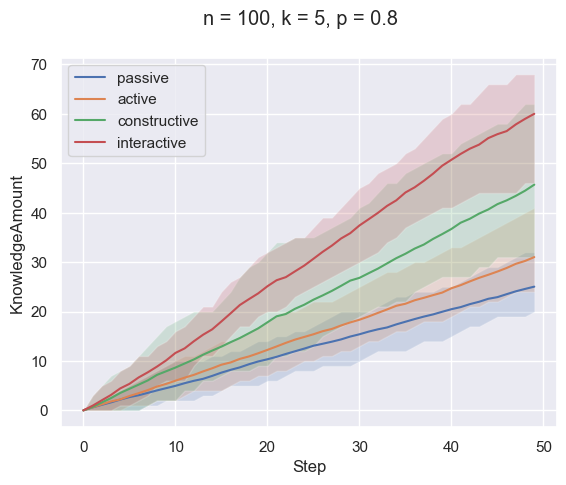

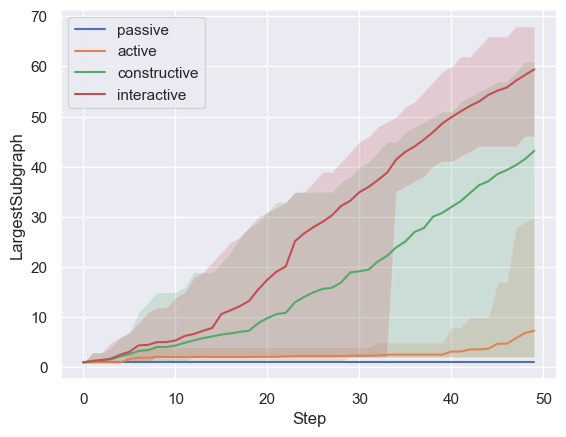

In [ ]:
# knowledge_graph = nx.Graph()
# for i in range(num_nodes):
#     knowledge_graph.add_node(i)

model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = 100)
df = simulate_ICAP_learning(model, 50, node_skip = 2)
plt.suptitle('n = {}, k = {}, p = {}'.format(num_nodes, k, p))
plot_ICAP_learning(df, agents_type, y = 'KnowledgeAmount')
plot_ICAP_learning(df, agents_type, y = 'LargestSubgraph')

In [ ]:
num_agents_by_type = {
                      'constructive': 50,
                      'interactive': 50
                      }
time_per_step_dict = {
                      'constructive': 1, 
                      'interactive': 1
                      }
res_interactive = []
res_constructive = []
ic_results = []
for _ in range(5):
  for (u, v) in knowledge_graph.edges():
    knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 1)

  model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = 100)
  df = simulate_ICAP_learning(model, 50, node_skip = 2)
  res_interactive += [np.mean(df[df.AgentType == 'interactive'].loc[49, 'KnowledgeAmount'])]

  for time in range(1, 10):
    steps = 50 + 3 * time
    df = simulate_ICAP_learning(model, steps, node_skip = 2)
    res_constructive += [np.mean(df[df.AgentType == 'constructive'].loc[steps - 1, 'KnowledgeAmount'])]
    if res_constructive[-1] - 1 < res_interactive[-1] < res_constructive[-1] + 1 or res_interactive[-1] < res_constructive[-1]:
      ic_results += [steps / 50]
      break

In [ ]:
np.mean(ic_results)

1.2879999999999998

## Constructive / Active

In [ ]:
num_agents_by_type = {
                      'constructive': 50,
                      'active': 50
                      }
time_per_step_dict = {
                      'constructive': 1, 
                      'active': 1
                      }
res_active = []
res_constructive = []
ac_results = []
for _ in range(5):
  for (u, v) in knowledge_graph.edges():
    knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 1)

  model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = 100)
  df = simulate_ICAP_learning(model, 50, node_skip = 2)
  res_constructive += [np.mean(df[df.AgentType == 'constructive'].loc[49, 'KnowledgeAmount'])]

  for time in range(1, 10):
    steps = 50 + 3 * time
    df = simulate_ICAP_learning(model, steps, node_skip = 2)
    res_active += [np.mean(df[df.AgentType == 'active'].loc[steps - 1, 'KnowledgeAmount'])]
    if res_active[-1] - 2 < res_constructive[-1] < res_active[-1] + 2 or res_constructive[-1] < res_active[-1]:
      ac_results += [steps / 50]
      break

## Active / Passive

In [ ]:
num_agents_by_type = {
                      'active': 50,
                      'passive': 50
                      }
time_per_step_dict = {
                      'active': 1, 
                      'passive': 1
                      }
res_active = []
res_passive = []
ap_results = []
for _ in range(5):
  for (u, v) in knowledge_graph.edges():
    knowledge_graph.edges[u,v]['weight'] = random.uniform(0, 1)

  model = ICAPModel(knowledge_graph, agents_type=agents_type, max_time = 100)
  df = simulate_ICAP_learning(model, 50, node_skip = 2)
  res_active += [np.mean(df[df.AgentType == 'active'].loc[49, 'KnowledgeAmount'])]

  for time in range(1, 10):
    steps = 50 + 2 * time
    df = simulate_ICAP_learning(model, steps, node_skip = 2)
    res_passive += [np.mean(df[df.AgentType == 'passive'].loc[steps - 1, 'KnowledgeAmount'])]
    if res_passive[-1] - 1 < res_active[-1] < res_passive[-1] + 1 or res_active[-1] < res_passive[-1]:
      ap_results += [steps / 50]
      break